# 1. Setup VizDoom

In [1]:
!pip install vizdoom

     --------------------------------------- 15.4/15.4 MB 16.1 kB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom

In [63]:
from vizdoom import *
import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Setup game
game = DoomGame() # from vizdoom
game.load_config('github/VizDoom/scenarios/basic.cfg')
game.init()

In [134]:
# Set of actions we can take in the environment
actions = np.identity(3,dtype=np.uint8) # move left, move right, attack

In [11]:
random.choice(actions)

array([1, 0, 0], dtype=uint8)

In [ ]:
episodes = 10
for episode in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables # ammo
        reward = game.make_action(random.choice(actions),4) # 4: skip frame, see the result of making a shot quicker
        print('reward:',reward)
        time.sleep(0.02)
    print('Result:',game.get_total_reward())
    time.sleep(2)

In [13]:
game.close()

# 2. Setup gym

In [100]:
from gym import Env, spaces
import cv2

In [114]:
# Create Vizdoom openAI Gym Enviroment
class VizDoomGym(Env):
    def __init__(self, render=False):
        super().__init__()
        self.game = DoomGame() # from vizdoom
        self.game.load_config('github/VizDoom/scenarios/basic.cfg')
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        self.observation_space = spaces.box.Box(low=0,high=255,shape=(100,160,1),dtype=np.uint8)
        self.action_space = spaces.discrete.Discrete(3)
        
    def step(self, action):
        # Specify action and take step
        actions = np.identity(3, dtype=np.uint8)
        reward = self.game.make_action(actions[action],4) # skip frame = 4
        
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo  = self.game.get_state().game_variables[0]
            info = {"ammo":ammo}
        else:
            state = np.zeros(self.observation_space.shape)
            info = {"ammo":0}
        
        done = self.game.is_episode_finished()
        
        return state, reward, done, info
    
    def close(self):
        self.game.close()
        
    def render():
        pass
    
    def grayscale(self, observation):
        # moveaxis(observation,0,-1) -> moves (3,240,320) to (240,320,3)
        gray = cv2.cvtColor(np.moveaxis(observation,0,-1),cv2.COLOR_BGR2GRAY)
        # make it smaller, scales it down
        resize = cv2.resize(gray,(160,100),interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize,(100,160,1))
        return state
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)

In [115]:
env = VizDoomGym(render=True)

In [75]:
state = env.reset()
state.shape

(100, 160, 1)

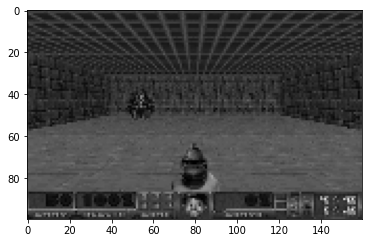

In [72]:
plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))

In [79]:
env.step(2)

(array([[[55],
         [50],
         [59],
         ...,
         [57],
         [57],
         [66]],
 
        [[68],
         [65],
         [65],
         ...,
         [56],
         [67],
         [72]],
 
        [[49],
         [79],
         [66],
         ...,
         [79],
         [51],
         [29]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 -4.0,
 False,
 array([49.]))

In [117]:
env.close()

In [85]:
# ENVIRONMENT Checker
from stable_baselines3.common import env_checker

In [116]:
env_checker.check_env(env)

# 3. Setup Callback

In [81]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [82]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [83]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [121]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# 4 Train Model

In [105]:
from stable_baselines3 import PPO

In [123]:
env = VizDoomGym()

In [128]:
model = PPO('CnnPolicy',env,tensorboard_log=LOG_DIR,verbose=1,learning_rate=0.0001,n_steps=2048)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=100000,callback=callback)

# 6. Test the Model

In [126]:
from stable_baselines3.common.evaluation import evaluate_policy

In [131]:
model = PPO.load('./train/train_basic/best_model_100000')

In [132]:
env = VizDoomGym(render=True)

In [ ]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

In [135]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.2)
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Total Reward for episode 0 is 83.0
Total Reward for episode 1 is 95.0
Total Reward for episode 2 is 95.0
Total Reward for episode 3 is 95.0
Total Reward for episode 4 is 95.0


In [136]:
env.close()